In [1]:
import intake
import xarray as xr
import zarr
import numpy as np

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../src/')))
#sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../weather_routing_old/src/')))

from weather_router import isochronal_weather_router, polar, point_validity, visualize


In [2]:
#LA = (33.6, -124)
#Honolulu = (21.3, -157.8)

Cape = (-34, 18)
Rio = (-22.9, -43.2)

min_lat = min(Cape[0], Rio[0]) - 5  
max_lat = max(Cape[0], Rio[0]) + 5  

min_lon = min(Cape[1], Rio[1]) - 1  
max_lon = max(Cape[1], Rio[1]) + 1  

In [3]:

if not os.path.exists('cache.zarr/'):
    print('Downloading data...')
    ds = xr.open_zarr(
        'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
        chunks=None,
        storage_options=dict(token='anon'),
    )
    ds = ds.rename({'latitude':'lat', 'longitude':'lon'})
    ds = ds[['10m_u_component_of_wind', '10m_v_component_of_wind']]
    ds.coords['lon'] = ((ds.coords['lon'] + 180) % 360) - 180
    ds = ds.sortby(ds.lon)
    ds = ds.sel(lat=slice(max_lat, min_lat), lon=slice(min_lon, max_lon))
    ds = ds.sel(time = slice('2025-01-01T12:00:00', '2025-01-18T12:00:00'))
    ds = ds.load()
    u10 = ds['10m_u_component_of_wind']
    v10 = ds['10m_v_component_of_wind']
    tws = xr.ufuncs.hypot(v10, u10)
    tws = tws*1.94384 #convert m/s to knots
    twd = (180 + np.rad2deg(np.arctan2(u10, v10))) % 360
    ds = tws.to_dataset(name = 'tws')
    ds['twd'] = twd
    ds.to_zarr('cache.zarr')
else:
    ds = xr.open_zarr('cache.zarr')

In [4]:
def get_wind(t, lat, lon):
    tws_sel = ds.tws.sel(time = t, method = 'nearest')
    tws_sel = tws_sel.sel(lat = lat, lon = lon, method = 'nearest')
    twd_sel = ds.twd.sel(time = t, method = 'nearest')
    twd_sel = twd_sel.sel(lat = lat, lon = lon, method = 'nearest')
    return (np.float32(twd_sel.values), np.float32(tws_sel.values))

In [5]:
volvo70_polar = polar.Polar('../test/volvo70.pol')

point_valid = point_validity.land_sea_mask().point_validity_arr

weatherrouter = isochronal_weather_router.weather_router(volvo70_polar, 
                                                         get_wind, 
                                                         time_steps = ds.time.values,
                                                         step = 1,
                                                         start_point = Cape,
                                                         end_point = Rio,
                                                         point_validity = point_valid,
                                                         spread = 140,
                                                         wake_lim = 50,
                                                         rounding = 2,
                                                         n_points=20,
                                                         )

In [6]:
weatherrouter.route()

0
1
8
2
11
3
16
4
16
5
15
6
15
7
16
8
17
9
16
10
15
11
15
12
15
13
15
14
17
15
17
16
16
17
15
18
18
19
19
20
16
21
16
22
18
23
19
24
19
25
17
26
19
27
17
28
19
29
17
30
18
31
12
32
15
33
14
34
14
35
15
36
14
37
15
38
17
39
18
40
15
41
15
42
15
43
18
44
15
45
15
46
17
47
15
48
14
49
16
50
14
51
16
52
16
53
17
54
14
55
14
56
15
57
17
58
18
59
14
60
16
61
15
62
15
63
16
64
18
65
15
66
14
67
14
68
14
69
14
70
16
71
16
72
12
73
15
74
16
75
16
76
16
77
18
78
17
79
16
80
16
81
17
82
15
83
17
84
17
85
15
86
19
87
19
88
18
89
18
90
17
91
15
92
17
93
16
94
19
95
18
96
15
97
18
98
17
99
16
100
17
101
18
102
17
103
19
104
17
105
18
106
20
107
13
108
19
109
15
110
16
111
18
112
14
113
15
114
17
115
17
116
17
117
18
118
17
119
19
120
18
121
17
122
16
123
17
124
13
125
14
126
16
127
9
128
14
129
14
130
14
131
15
132
15
133
18
134
18
135
17
136
17
137
17
138
16
139
17
140
19
141
18
142
18
143
17
144
19
145
14
146
16
147
17
148
15
149
15
150
17
151
15
152
17
153
15
154
15
155
17
156
18
157
16
158
17
15

In [7]:
route_df = weatherrouter.get_fastest_route()
route_df

,lat,lon,time,twd,tws,pos,next_pos,heading,twa,base_boat_speed,is_tacking,boat_speed,hours_elapsed,days_elapsed
0,-34.000000,18.000000,2025-01-01 12:00:00,232.094025,10.638941,"(-34.0, 18.0)","(-33.83530685707055, 17.794895521881806)",314.000000,81.905975,14.22,False,14.22,0,0.000000
1,-33.835307,17.794896,2025-01-01 13:00:00,225.420486,12.146090,"(-33.83530685707055, 17.794895521881806)","(-33.69310947522205, 17.54197715983982)",304.000000,78.579514,15.24,False,15.24,1,0.041667
2,-33.693109,17.541977,2025-01-01 14:00:00,229.544617,13.184561,"(-33.69310947522205, 17.54197715983982)","(-33.54642654074991, 17.281536568427235)",304.000000,74.455383,15.72,False,15.72,2,0.083333
3,-33.546427,17.281537,2025-01-01 15:00:00,221.543182,13.329449,"(-33.54642654074991, 17.281536568427235)","(-33.39469681634189, 17.01262078947876)",304.000000,82.456818,16.26,False,16.26,3,0.125000
4,-33.394697,17.012621,2025-01-01 16:00:00,219.955811,14.590051,"(-33.39469681634189, 17.01262078947876)","(-33.218279580868845, 16.70067514572221)",304.000000,84.044189,18.90,False,18.90,4,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,-23.308435,-42.333347,2025-01-11 14:00:00,218.159515,5.847869,"(-23.308434768937357, -42.33334738874481)","(-23.247630100505216, -42.468902014433525)",296.000000,77.840485,8.32,False,8.32,242,10.083333
243,-23.247630,-42.468902,2025-01-11 15:00:00,209.985275,6.507472,"(-23.247630100505216, -42.468902014433525)","(-23.229647736251003, -42.62757087119354)",277.000000,67.014725,8.82,False,8.82,243,10.125000
244,-23.229648,-42.627571,2025-01-11 16:00:00,189.090393,7.897946,"(-23.229647736251003, -42.62757087119354)","(-23.133132834090254, -42.8020690316782)",301.000000,111.909607,11.24,False,11.24,244,10.166667
245,-23.133133,-42.802069,2025-01-11 17:00:00,180.724152,9.306396,"(-23.133132834090254, -42.8020690316782)","(-23.12581488285722, -43.0250570815599)",272.000000,91.275848,12.32,False,12.32,245,10.208333


In [8]:
initial_route = weatherrouter.get_fastest_route(stats=False)
initial_isochrones = weatherrouter.get_isochrones()

optimized_route = weatherrouter.optimize(initial_route, initial_isochrones)

Starting optimization pass...
constraint overriden
Optimize step 0
Optimize step 1
Optimize isochrone points: 8, dist_wp_min: 3240.8694949076935
Optimize step 2
Optimize isochrone points: 16, dist_wp_min: 3228.829613075504
Optimize step 3
Optimize isochrone points: 31, dist_wp_min: 3216.154573560798
Optimize step 4
Optimize isochrone points: 23, dist_wp_min: 3203.472043082612
Optimize step 5
Optimize isochrone points: 24, dist_wp_min: 3188.0917680532125
Optimize step 6
Optimize isochrone points: 26, dist_wp_min: 3172.175882764353
Optimize step 7
Optimize isochrone points: 26, dist_wp_min: 3155.4485818442163
Optimize step 8
Optimize isochrone points: 25, dist_wp_min: 3138.2207194449775
Optimize step 9
Optimize isochrone points: 26, dist_wp_min: 3120.297248599958
Optimize step 10
Optimize isochrone points: 28, dist_wp_min: 3103.6138894538676
Optimize step 11
Optimize isochrone points: 27, dist_wp_min: 3087.881150875804
Optimize step 12
Optimize isochrone points: 24, dist_wp_min: 3071.925

In [9]:
route_df = weatherrouter.get_fastest_route()
route_df

,lat,lon,time,twd,tws,pos,next_pos,heading,twa,base_boat_speed,is_tacking,boat_speed,hours_elapsed,days_elapsed
0,-34.000000,18.000000,2025-01-01 12:00:00,232.094025,10.638941,"(-34.0, 18.0)","(-33.83530685707055, 17.794895521881806)",314.000000,81.905975,14.22,False,14.22,0,0.000000
1,-33.835307,17.794896,2025-01-01 13:00:00,225.420486,12.146090,"(-33.83530685707055, 17.794895521881806)","(-33.69310947522205, 17.54197715983982)",304.000000,78.579514,15.24,False,15.24,1,0.041667
2,-33.693109,17.541977,2025-01-01 14:00:00,229.544617,13.184561,"(-33.69310947522205, 17.54197715983982)","(-33.54642654074991, 17.281536568427235)",304.000000,74.455383,15.72,False,15.72,2,0.083333
3,-33.546427,17.281537,2025-01-01 15:00:00,221.543182,13.329449,"(-33.54642654074991, 17.281536568427235)","(-33.39469681634189, 17.01262078947876)",304.000000,82.456818,16.26,False,16.26,3,0.125000
4,-33.394697,17.012621,2025-01-01 16:00:00,219.955811,14.590051,"(-33.39469681634189, 17.01262078947876)","(-33.218279580868845, 16.70067514572221)",304.000000,84.044189,18.90,False,18.90,4,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,-23.277431,-42.681106,2025-01-11 09:00:00,260.664612,6.398579,"(-23.277430679641643, -42.681106248339084)","(-23.18952779334511, -42.767187984567656)",318.000000,57.335388,7.10,False,7.10,237,9.875000
238,-23.189528,-42.767188,2025-01-11 10:00:00,237.338730,4.357839,"(-23.18952779334511, -42.767187984567656)","(-23.15403020925716, -42.849931314948776)",295.000000,57.661270,5.04,False,5.04,238,9.916667
239,-23.154030,-42.849931,2025-01-11 11:00:00,235.891174,4.296618,"(-23.15403020925716, -42.849931314948776)","(-23.132190927294733, -42.922965836365265)",288.000000,52.108826,4.24,False,4.24,239,9.958333
240,-23.132191,-42.922966,2025-01-11 12:00:00,233.223206,3.782576,"(-23.132190927294733, -42.922965836365265)","(-23.130414334780408, -42.97799072828037)",272.000000,38.776794,3.04,False,3.04,240,10.000000


In [10]:
route_df.columns

Index(['lat', 'lon', 'time', 'twd', 'tws', 'pos', 'next_pos', 'heading', 'twa',
       'base_boat_speed', 'is_tacking', 'boat_speed', 'hours_elapsed',
       'days_elapsed'],
      dtype='object')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
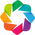

In [11]:
import holoviews as hv
hv.extension('bokeh')

In [12]:
viz = visualize.visualize(ds, Cape, Rio, route_df, filename='route1')
viz.return_plot()

BokehModel(combine_events=True, render_bundle={'docs_json': {'fec3ae53-db87-4e4c-a88e-afecf229d095': {'version…